In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os

import pandas as pd
import xarray as xr
import pyomo.core as po
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calliope
from calliope.core.util.dataset import split_loc_techs

idx = pd.IndexSlice

In [3]:
calliope.set_log_verbosity()

In [4]:
model_files = glob.glob('../outputs/resolution_test/*.nc')
models = {
    os.path.basename(file).replace(".nc", ""): calliope.read_netcdf(file)
    for file in model_files
}

[2021-03-24 11:00:48] INFO     Model: initialising
[2021-03-24 11:01:27] INFO     Model: loaded model_data
[2021-03-24 11:01:38] INFO     Model: initialising
[2021-03-24 11:02:17] INFO     Model: loaded model_data
[2021-03-24 11:02:28] INFO     Model: initialising
[2021-03-24 11:03:07] INFO     Model: loaded model_data


In [5]:
tech_groups = {
    'ac_ohl_mountain_transmission': 'transmission',
    'ac_ohl_transmission': 'transmission',
    'battery': 'storage',
    'dc_ohl_transmission': 'transmission',
    'dc_subsea_transmission': 'transmission',
    'dc_underground_transmission': 'transmission',
    'hydro_reservoir': 'hydro',
    'hydro_run_of_river': 'hydro',
    'hydrogen_storage': 'storage',
    'open_field_pv': 'pv',
    'pumped_hydro': 'storage',
    'methane_storage': 'storage',
    'roof_mounted_pv': 'pv',
    'wind_offshore': 'wind_off',
    'wind_onshore_competing': 'wind_on',
    'wind_onshore_monopoly': 'wind_on',
    'electrolysis': 'electrolysis',
    'biofuel_boiler': 'boiler',
    'methane_boiler': 'boiler',
    'electric_heater': 'electrified_heat',
    'hp': 'electrified_heat',
    'gas_hob': 'gas_cooking',
    'electric_hob': 'electrified_cooking',
    'waste_supply': 'waste_incineration',
    'ccgt': 'gas_powered_electricity',
    #'heavy_transport_ev': 'EV transport',
    #'heavy_transport_ice': 'ICE transport',
    #'light_transport_ev': 'EV transport',
    #'light_transport_ice': 'ICE transport',
    'biofuel_to_diesel': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_liquids': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_methane': 'biofuel derived\nsynthetic fuel',
    'hydrogen_to_diesel': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_liquids': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_methane': 'hydrogen derived\nsynthetic fuel'
}

In [6]:
model_names = {
    'link_cap_dynamic,res_2h': 2, 
    'link_cap_dynamic': 1, 
    'link_cap_dynamic,res_12h': 12, 
    'link_cap_dynamic,res_3h': 3, 
    'link_cap_dynamic,res_6h': 6
}

In [7]:
energy_cap = (
    pd.concat(
        [split_loc_techs(v.results.energy_cap, return_as='Series') for v in models.values()], 
        axis=0, sort=True, names=['resolution_h'], 
        keys=[model_names[k] for k in models.keys()]
    )
    .where(lambda x: x > 1e-5).dropna()
    .sum(level=['resolution_h', 'techs'])
    .unstack('resolution_h')
)
energy_cap.index = energy_cap.index.str.split(':', expand=True)
energy_cap = energy_cap.groupby(level=0).sum()
energy_cap.loc[energy_cap.index.str.find('transmission') > -1] /= 2

In [8]:
energy_cap_grouped = energy_cap.groupby(tech_groups).sum()

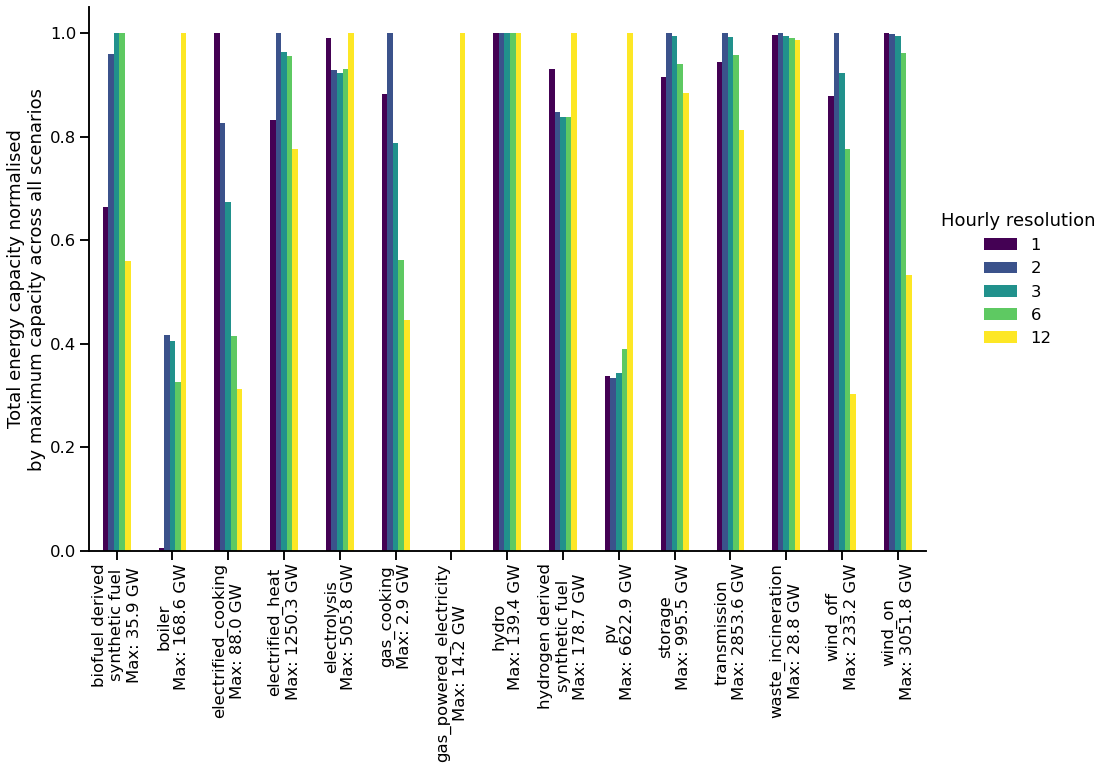

In [9]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    energy_cap_grouped.div(energy_cap_grouped.max(axis=1), axis=0).sort_index(axis=1).plot.bar(ax=ax, cmap="viridis")
    xlabels = ["{}\nMax: {:.1f} GW".format(tech, energy_cap_grouped.max(axis=1).loc[tech] * 100) for tech in energy_cap_grouped.index]
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Hourly resolution', frameon=False)
    ax.set_ylabel('Total energy capacity normalised\nby maximum capacity across all scenarios')

    ax.set_xticklabels(xlabels)
    sns.despine()

# Look at hourly production in the 1hr resolution model

In [10]:
tech_groups = {
    'wind_offshore': 'offshore wind',
    'wind_onshore_competing': 'onshore wind',
    'wind_onshore_monopoly': 'onshore wind',
    'open_field_pv': 'pv',
    'roof_mounted_pv': 'pv',
    'hydro_reservoir': 'hydro',
    'hydro_run_of_river': 'hydro',
    'ccgt': 'gas_powered_electricity',
    'chp_biofuel_extraction': 'CHP',
    'chp_methane_extraction': 'CHP',
    'chp_wte_back_pressure': 'CHP',
    'nuclear': 'nuclear',
    'battery': 'storage',
    'hydrogen_storage': 'storage',
    'pumped_hydro': 'storage',
    'methane_storage': 'storage',
    'electrolysis': 'electrolysis',
    'dac': 'Direct air capture',
    'electric_heater': 'electrified_heat',
    'hp': 'electrified_heat',
    'electric_hob': 'electrified_cooking',
    'heavy_transport_ev': 'EV transport',
    'light_transport_ev': 'EV transport',
    'biofuel_to_diesel': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_liquids': 'biofuel derived\nsynthetic fuel',
    'biofuel_to_methane': 'biofuel derived\nsynthetic fuel',
    'hydrogen_to_diesel': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_liquids': 'hydrogen derived\nsynthetic fuel',
    'hydrogen_to_methane': 'hydrogen derived\nsynthetic fuel',
    'demand_elec': 'Eletricity demand'
}

In [11]:
prod = models['link_cap_dynamic'].get_formatted_array('carrier_prod').to_series().where(lambda x: x > 0).dropna()
con = models['link_cap_dynamic'].get_formatted_array('carrier_con').to_series().where(lambda x: x < 0).dropna()

In [12]:
_df = prod.add(con, fill_value=0).xs('electricity')

In [13]:
timeslices = {
    'winter': slice('2016-01-01', '2016-01-07'),
    'summer': slice('2016-07-01', '2016-07-07')   
}

In [14]:
_df2 = _df.sum(level=['techs', 'timesteps']).unstack('techs')
_df2.index = pd.to_datetime(_df2.index)
_df2 = _df2.groupby(tech_groups, axis=1).sum()

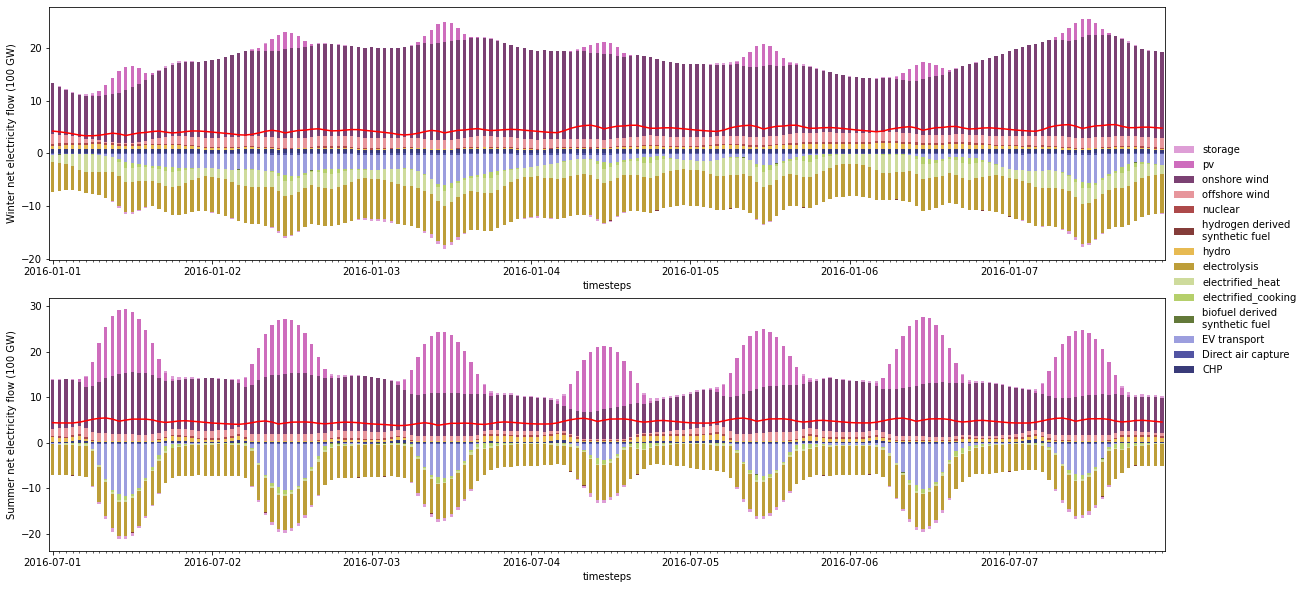

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'hspace': 0.15})
_ax = 0
legend = True
for season, timeslice in timeslices.items():
    season_df = _df2.loc[timeslice].where(lambda x: abs(x) > 1e-5).dropna(how='all', axis=1)
    demand = season_df['Eletricity demand']
    not_demand = season_df.drop('Eletricity demand', axis=1)
    not_demand.plot.bar(stacked=True, ax=ax[_ax], cmap='tab20b', legend=legend, ec="None", lw=0)
    ax[_ax].plot(-1 * demand.values, c='red')
    
    xlabels = [i.get_text().split(" ")[0] for i in ax[_ax].get_xticklabels()[::24]]
    ax[_ax].set_xticks(ax[_ax].get_xticks()[::24])
    ax[_ax].set_xticks([i for i in range(len(season_df.index)) if i not in ax[_ax].get_xticks()], minor=True)
    ax[_ax].set_xticklabels(xlabels, rotation=0)
    ax[_ax].set_ylabel(f"{season.title()} net electricity flow (100 GW)")
    _ax += 1
    legend=False

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc=('center left'), bbox_to_anchor=(1, 0), frameon=False)


# What happens with EV charging? Do we need to set a weekly charge demand for transport?
Answer = Yes (look at how many regions barely do any charging in January)

In [16]:
_ev = con.xs('electricity').loc[pd.IndexSlice[:, ['heavy_transport_ev', 'light_transport_ev'], :]].unstack('timesteps')
_ev.columns = pd.to_datetime(_ev.columns)
_ev_weekly = _ev.resample('W-Mon', axis=1).sum()
_ev_weekly_contribution = _ev_weekly.div(_ev_weekly.sum(axis=1), axis=0)#

Text(0, 0.5, 'Cumulative contribution of each week\nto total EV electricity supply')

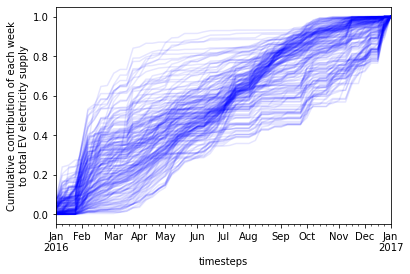

In [113]:
# pre-weekly demand result
ax = _ev_weekly_contribution.cumsum(axis=1).T.plot(c='blue', alpha=0.1, legend=False)
ax.set_ylabel('Cumulative contribution of each week\nto total EV electricity supply')

Text(0, 0.5, 'Cumulative contribution of each week\nto total EV electricity supply')

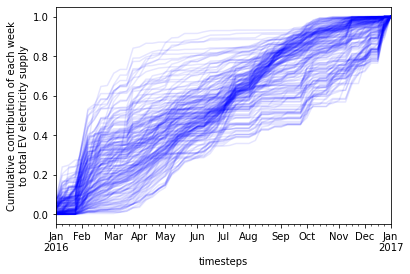

In [17]:
# post-weekly demand constraint
ax = _ev_weekly_contribution.cumsum(axis=1).T.plot(c='blue', alpha=0.1, legend=False)
ax.set_ylabel('Cumulative contribution of each week\nto total EV electricity supply')

# How is heat demand met?

In [116]:
prod.xs('heat').sum(level='techs').div(prod.xs('heat').sum())

techs
biofuel_tech_heat_to_demand                   0.000018
chp_biofuel_extraction_tech_heat_to_demand    0.192260
chp_methane_extraction_tech_heat_to_demand    0.000003
electric_heater_tech_heat_to_demand           0.000065
hp_tech_heat_to_demand                        0.807505
methane_tech_heat_to_demand                   0.000043
chp_wte_back_pressure_tech_heat_to_demand     0.000106
Name: carrier_prod, dtype: float64

# While we have it here, prep input/result data from 1hr model for ENVIRO

In [141]:
for k, v in models['link_cap_dynamic']._model_data.data_vars.items():
    if v.dtype.kind == "O":
        print(k)

resource_unit
lookup_remotes
colors
inheritance
names
lookup_loc_carriers
lookup_loc_techs
lookup_loc_techs_conversion
lookup_primary_loc_tech_carriers_in
lookup_primary_loc_tech_carriers_out
lookup_loc_techs_conversion_plus
lookup_loc_techs_area


In [148]:
for io in ['inputs', 'results']:
    for var_name, var in getattr(models['link_cap_dynamic'], io).data_vars.items():
        _df = split_loc_techs(var, return_as="Series").dropna()
        dims_to_keep = [i for i in _df.index.names if i not in ['locs', 'timesteps']]
        if var_name == "names":
            _df.to_csv(f'../outputs/data_for_sentinel_partners/enviro/{io}/{var_name}.csv')
        elif _df.dtype.kind in ("S", "M", "O"):
            continue
        if not dims_to_keep:
            _df = _df.to_frame('Total').sum()
        else:
            _df = _df.sum(level=dims_to_keep, min_count=1)
        if 'techs' in _df.index.names and len(_df.index.names) > 1:
            _df = _df.unstack('techs')
            _df.columns = _df.columns.str.split(':', expand=True)
            _df = _df.groupby(level=0, axis=1).sum(min_count=1).rename_axis(columns='techs').stack()
        _df = _df.dropna()
        _df.to_csv(f'../outputs/data_for_sentinel_partners/enviro/{io}/{var_name}.csv')
        print(f'Saved {var_name} to {io}')

Saved force_resource to inputs
Saved energy_cap_per_storage_cap_max to inputs
Saved lifetime to inputs
Saved resource to inputs
Saved energy_cap_max to inputs
Saved capacity_factor_max to inputs
Saved resource_eff to inputs
Saved energy_cap_min to inputs
Saved cv to inputs
Saved storage_cap_max to inputs
Saved energy_cap_equals to inputs
Saved resource_area_per_energy_cap to inputs
Saved energy_prod to inputs
Saved energy_cap_max_time_varying to inputs
Saved storage_loss to inputs
Saved energy_con to inputs
Saved energy_cap_per_storage_cap to inputs
Saved energy_eff to inputs
Saved capacity_factor_min to inputs
Saved storage_cap_equals to inputs
Saved cb to inputs
Saved cost_om_annual to inputs
Saved cost_om_prod to inputs
Saved cost_depreciation_rate to inputs
Saved cost_om_con to inputs
Saved cost_storage_cap to inputs
Saved cost_energy_cap to inputs
Saved cost_om_annual_investment_fraction to inputs
Saved distance to inputs
Saved available_area to inputs
Saved loc_coordinates to inp